# Autoencoders and Variational Autoencoders



**Author**: Matthew Stewart


<hr style="height:2pt">

In [1]:
 !pip install imgaug

    100% |████████████████████████████████| 686kB 6.6MB/s eta 0:00:01
    100% |████████████████████████████████| 1.6MB 6.9MB/s eta 0:00:01
    100% |████████████████████████████████| 52.1MB 375kB/s eta 0:00:01


In [3]:
#If having errors with importing modules, numpy may be an invalid version
#!pip install numpy==1.15.4

    100% |████████████████████████████████| 24.5MB 796kB/s eta 0:00:01
  Found existing installation: numpy 1.16.0
    Uninstalling numpy-1.16.0:
      Successfully uninstalled numpy-1.16.0


In [5]:
#If having errors with importing modules, scikit may be an invalid version
#!pip install -U scikit-image

    100% |████████████████████████████████| 29.2MB 690kB/s eta 0:00:01
  Found existing installation: scikit-image 0.14.1
    Uninstalling scikit-image-0.14.1:
      Successfully uninstalled scikit-image-0.14.1


In [9]:
## load the libraries 
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.metrics import *
from keras.optimizers import Adam, RMSprop
from scipy.stats import norm
from keras.preprocessing import image
from keras import datasets

from keras import backend as K

from imgaug import augmenters
import matplotlib.pyplot as plt
plt.gray()

<Figure size 432x288 with 0 Axes>

## Part 1: Data

### Reading data

Download the data given at the following link: <insert_link>. Use pandas and numpy to read in the data as a matrix

In [10]:
## Download the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 1s 0us/step


In [12]:
## normalize and reshape
x_train = x_train/255.
x_test = x_test/255.

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [13]:
x_train.shape

(60000, 28, 28, 1)

### Visualizing Samples

Visualize 10 images from dataset

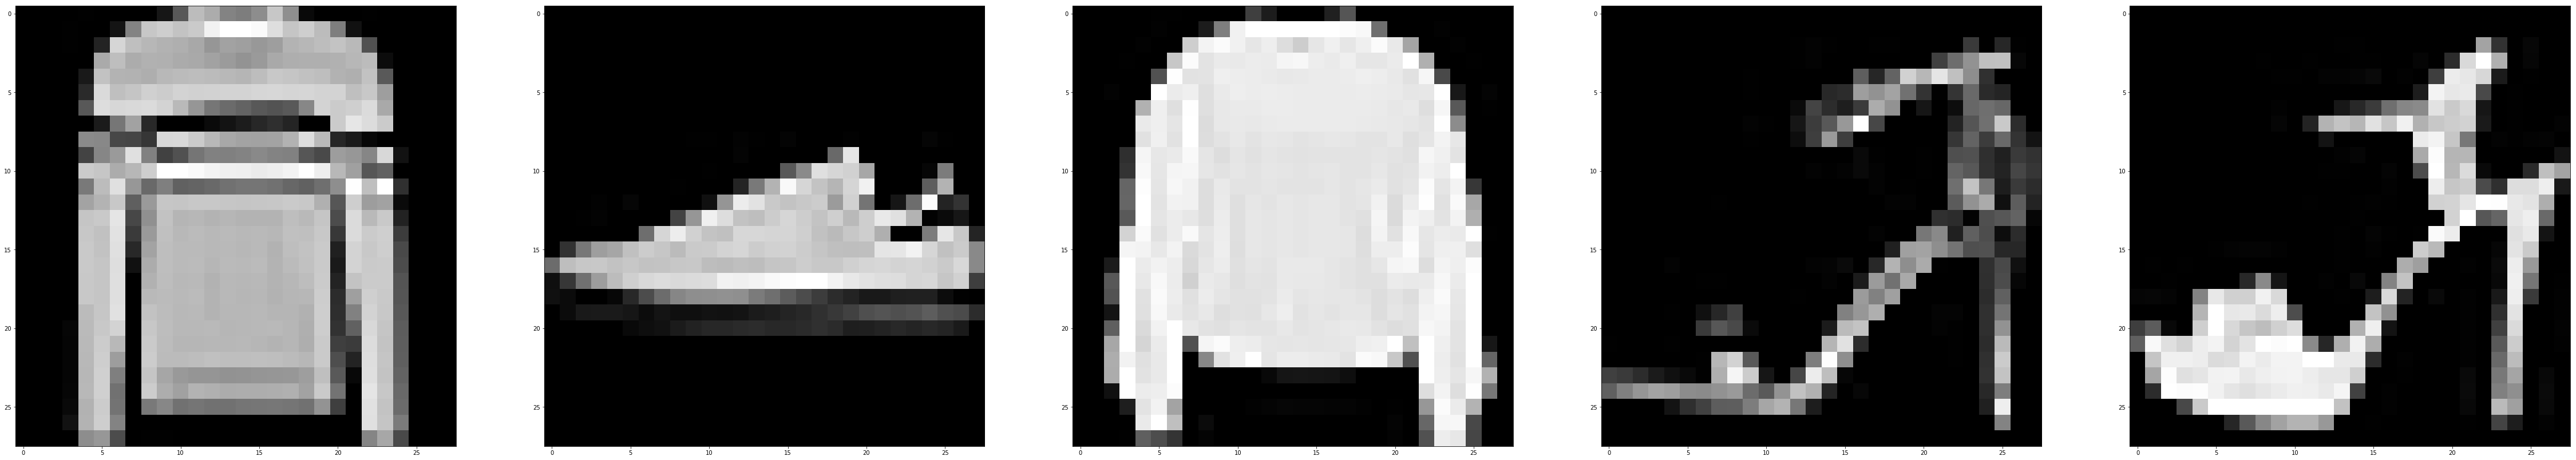

In [14]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(x_train[i, :, :, 0].reshape(28, 28))

## Part 2: Denoise Images using AEs

### Understanding AEs

![Autoencoders](https://cdn-images-1.medium.com/max/1600/1*ZEvDcg1LP7xvrTSHt0B5-Q@2x.png)

### Add Noise to Images

Check out [imgaug docs](https://imgaug.readthedocs.io/en/latest/source/api_augmenters_arithmetic.html) for more info and other ways to add noise.

In [16]:
# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(x_train * 255) / 255
val_x_n = seq_object.augment_images(x_test * 255) / 255

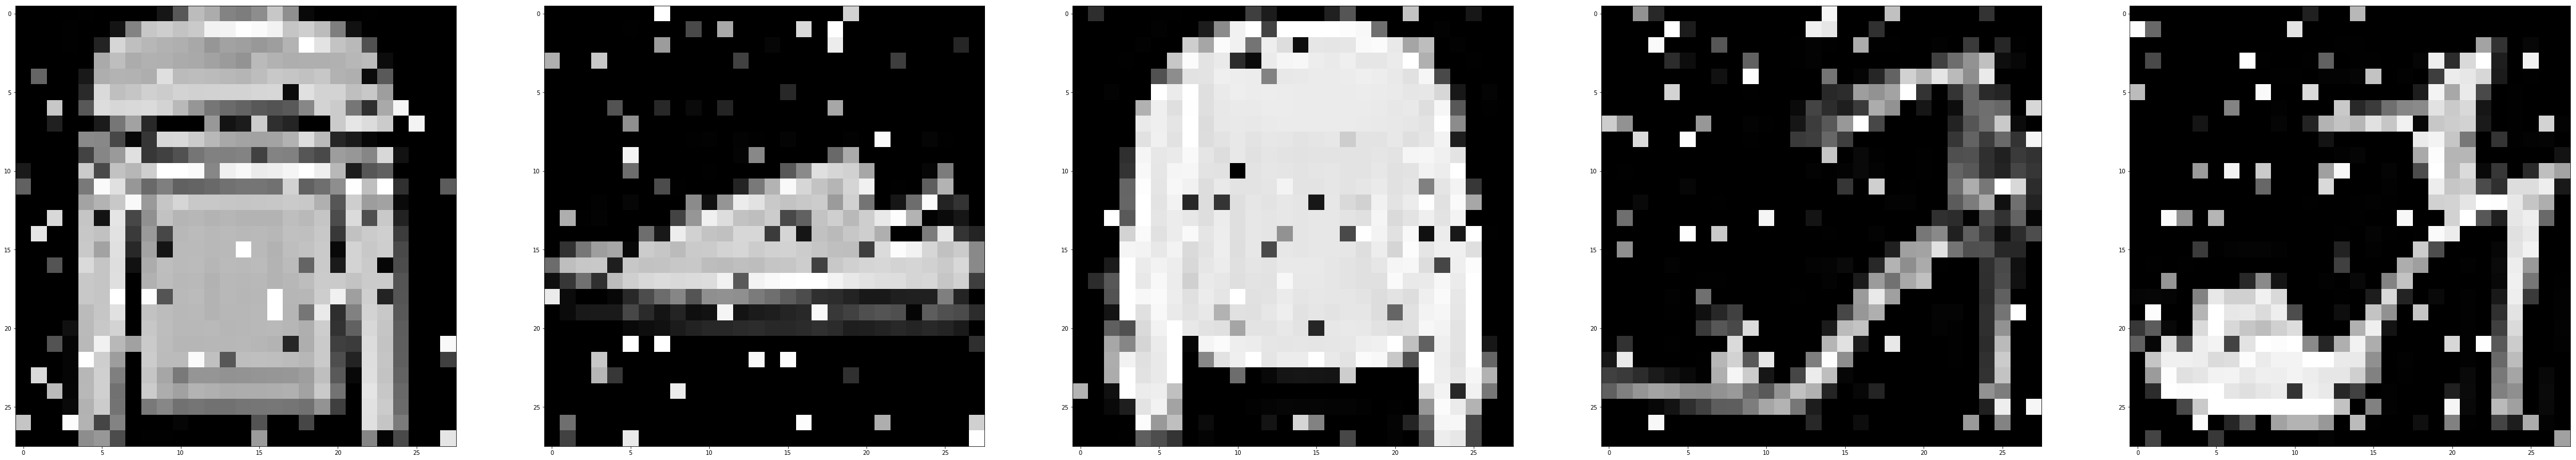

In [17]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i, :, :, 0].reshape(28, 28))

### Setup Encoder Neural Network

Try different number of hidden layers, nodes?

In [18]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

### Setup Decoder Neural Network

Try different number of hidden layers, nodes?

In [19]:
# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

### Train AE

In [20]:
# compile the model
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0         
__________

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model.fit(train_x_n, x_train, epochs=20, batch_size=2048, validation_data=(val_x_n, x_test), callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 183s 3ms/step - loss: 0.0877 - val_loss: 0.0513
Epoch 2/20
60000/60000 [==============================] - 244s 4ms/step - loss: 0.0417 - val_loss: 0.0346
Epoch 3/20
 4096/60000 [=>............................] - ETA: 3:45 - loss: 0.0345

KeyboardInterrupt: 

### Visualize Intermediate Layers of AE

Visualize intermediate layers

In [14]:
# compile the model
model_2 = Model(input_layer, latent_view)
model_2.compile(optimizer='adam', loss='mse')

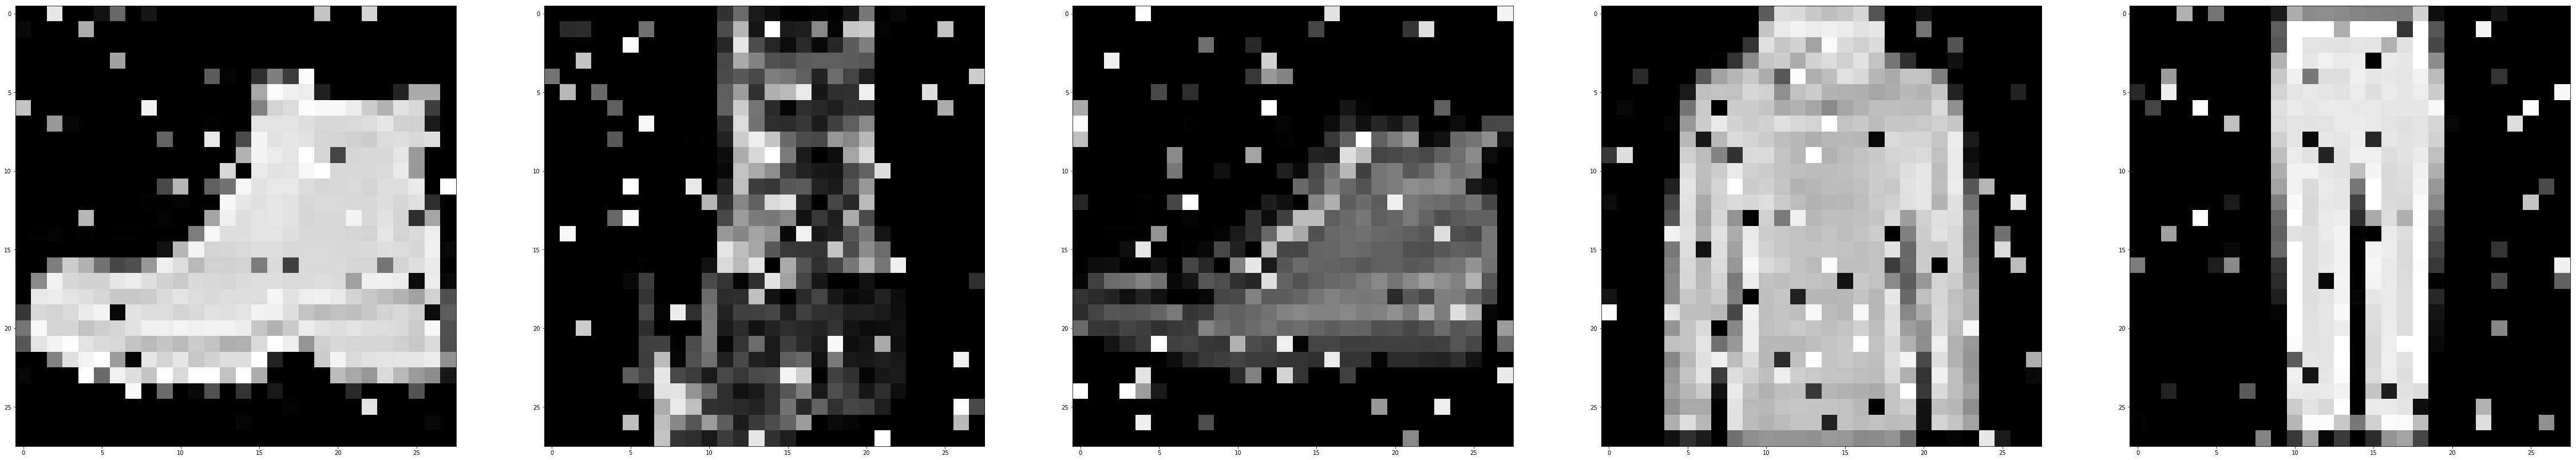

In [15]:
n = np.random.randint(0,len(val_x)-5)
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(val_x_n[a, :, :, 0].reshape(28, 28))
plt.show()

In [16]:
preds = model_2.predict(val_x_n[n:n+5])
preds.shape

(5, 4, 4, 16)

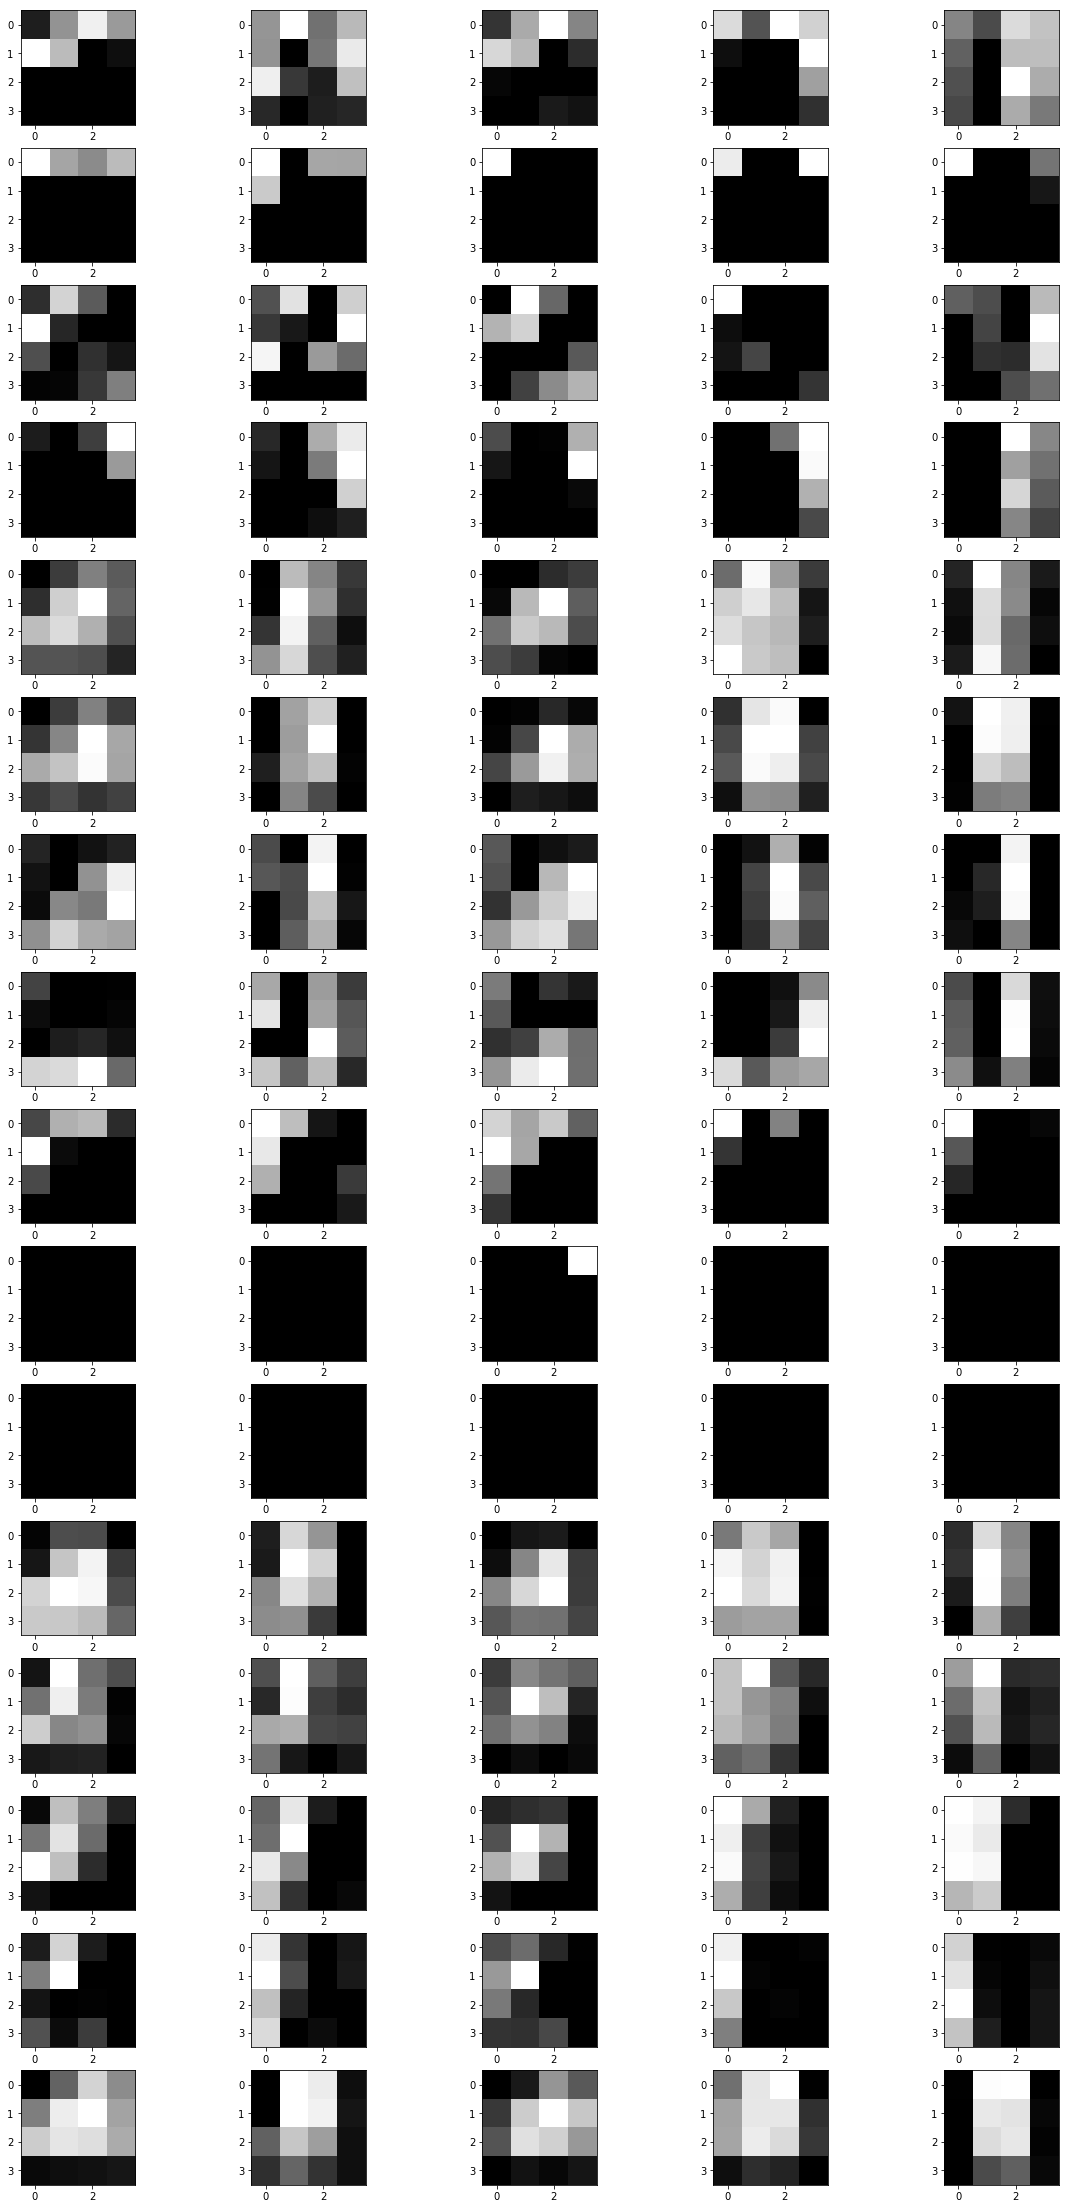

In [17]:
f, ax = plt.subplots(16,5)
ax = ax.ravel()
f.set_size_inches(20, 40)
for j in range(16):
    for i,a in enumerate(range(n,n+5)):
        ax[j*5 + i].imshow(preds[i, :, :, j])
plt.show()

### Visualize Samples reconstructed by AE

In [18]:
n = np.random.randint(0,len(val_x)-5)

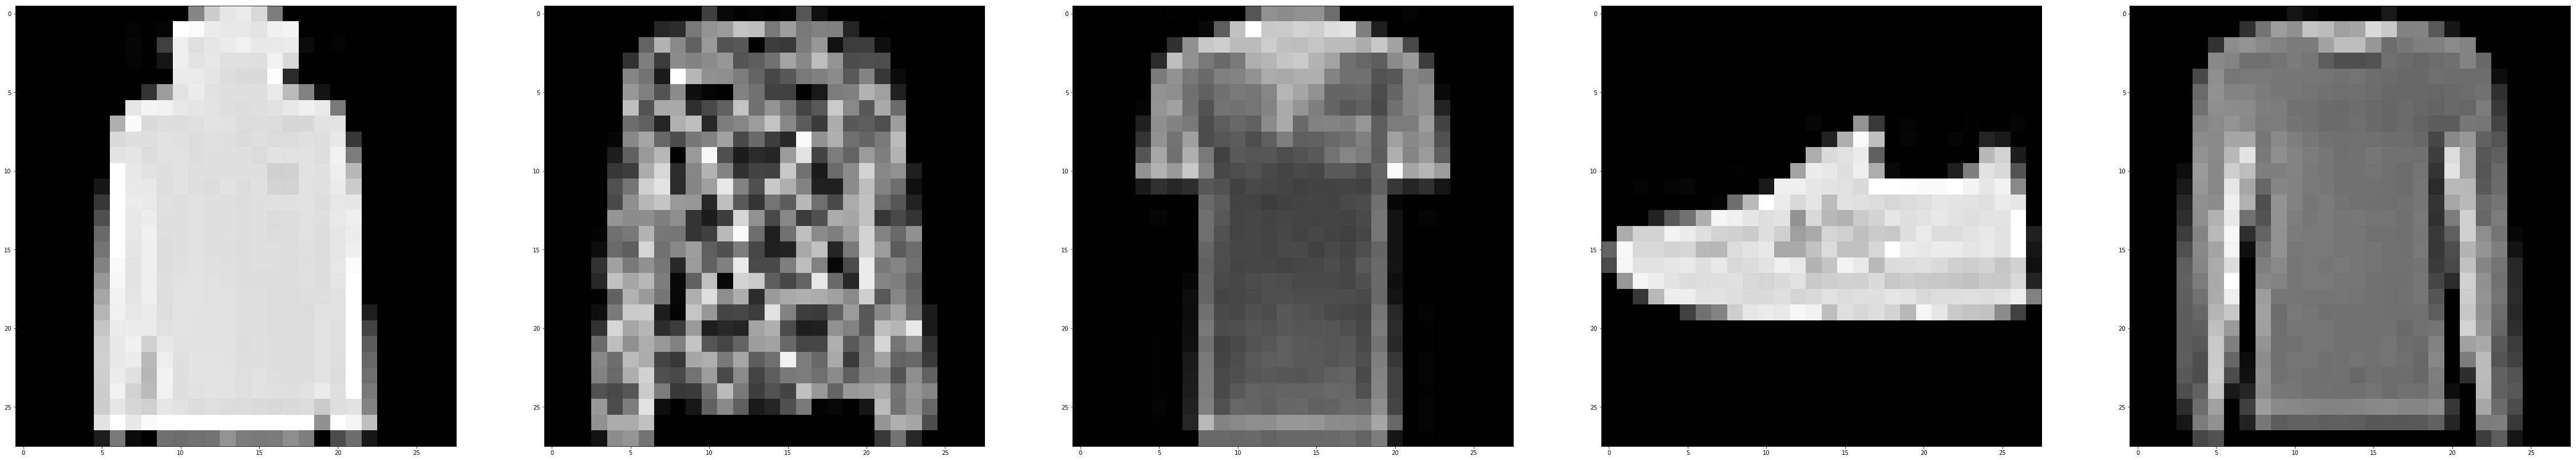

In [19]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(val_x[a, :, :, 0].reshape(28, 28))

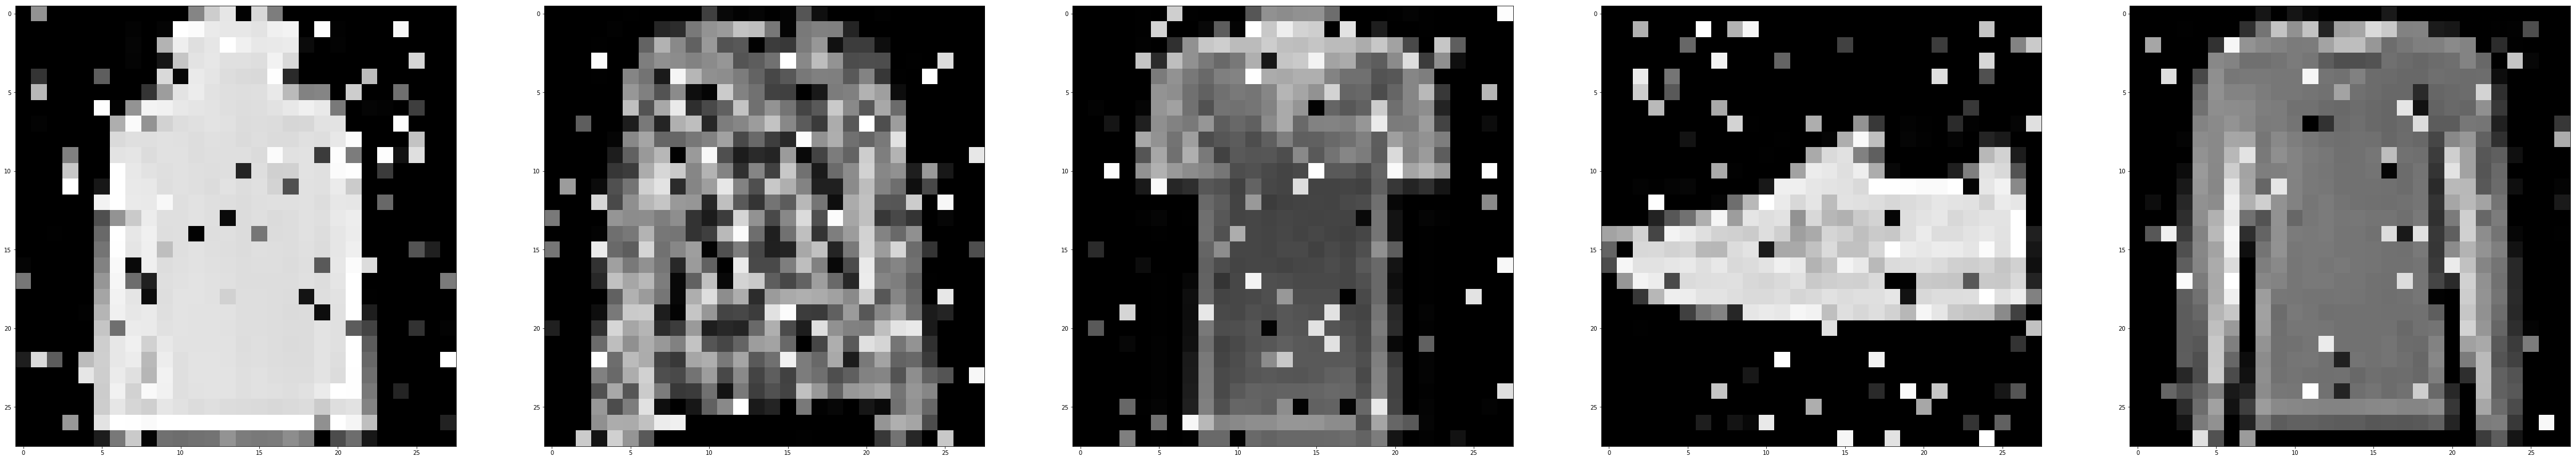

In [20]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(val_x_n[a, :, :, 0].reshape(28, 28))

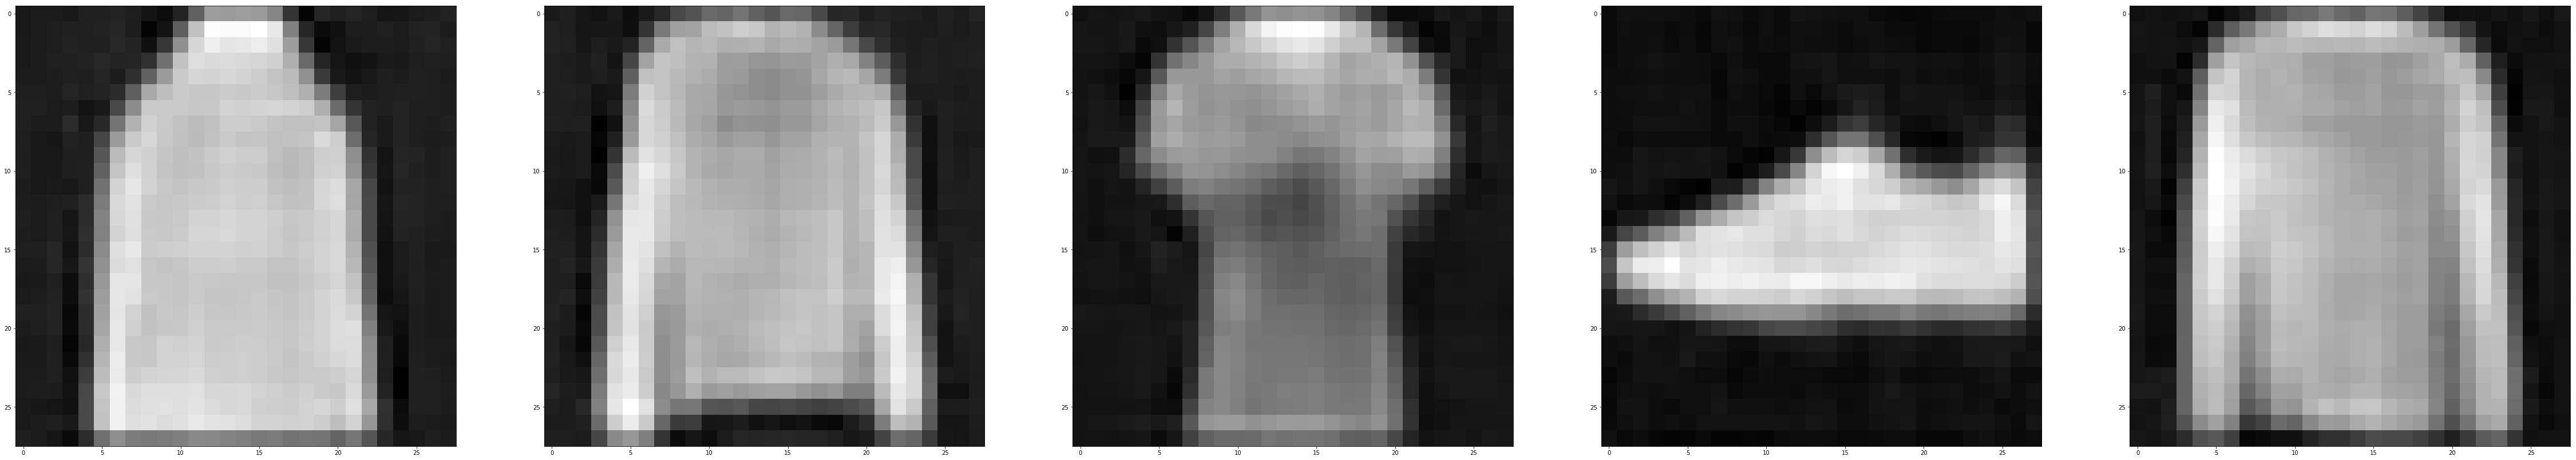

In [21]:
preds = model.predict(val_x_n[n:n+5])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

## Part 3: Exercise: Denoising noisy documents

In [32]:
!unzip data/noisy_docs_data.zip

Archive:  data/noisy_docs_data.zip
   creating: test/
  inflating: test/88.png             
   creating: __MACOSX/
   creating: __MACOSX/test/
  inflating: __MACOSX/test/._88.png  
  inflating: test/214.png            
  inflating: __MACOSX/test/._214.png  
  inflating: test/76.png             
  inflating: __MACOSX/test/._76.png  
  inflating: test/163.png            
  inflating: __MACOSX/test/._163.png  
  inflating: test/175.png            
  inflating: __MACOSX/test/._175.png  
  inflating: test/202.png            
  inflating: __MACOSX/test/._202.png  
  inflating: test/49.png             
  inflating: __MACOSX/test/._49.png  
  inflating: test/61.png             
  inflating: __MACOSX/test/._61.png  
  inflating: test/160.png            
  inflating: __MACOSX/test/._160.png  
  inflating: test/148.png            
  inflating: __MACOSX/test/._148.png  
  inflating: test/70.png             
  inflating: __MACOSX/test/._70.png  
  inflating: test/64.png             
  inflating: __

  inflating: train_cleaned/167.png   
  inflating: __MACOSX/train_cleaned/._167.png  
  inflating: train_cleaned/99.png    
  inflating: __MACOSX/train_cleaned/._99.png  
  inflating: train_cleaned/8.png     
  inflating: __MACOSX/train_cleaned/._8.png  
  inflating: train_cleaned/72.png    
  inflating: __MACOSX/train_cleaned/._72.png  
  inflating: train_cleaned/198.png   
  inflating: __MACOSX/train_cleaned/._198.png  
  inflating: train_cleaned/66.png    
  inflating: __MACOSX/train_cleaned/._66.png  
  inflating: train_cleaned/210.png   
  inflating: __MACOSX/train_cleaned/._210.png  
  inflating: train_cleaned/204.png   
  inflating: __MACOSX/train_cleaned/._204.png  
  inflating: train_cleaned/9.png     
  inflating: __MACOSX/train_cleaned/._9.png  
  inflating: train_cleaned/98.png    
  inflating: __MACOSX/train_cleaned/._98.png  
  inflating: train_cleaned/129.png   
  inflating: __MACOSX/train_cleaned/._129.png  
  inflating: train_cleaned/101.png   
  inflating: __MACOSX/tr

  inflating: train/74.png            
  inflating: __MACOSX/train/._74.png  
  inflating: train/48.png            
  inflating: __MACOSX/train/._48.png  
  inflating: train/203.png           
  inflating: __MACOSX/train/._203.png  
  inflating: train/216.png           
  inflating: __MACOSX/train/._216.png  
  inflating: train/75.png            
  inflating: __MACOSX/train/._75.png  
  inflating: train/174.png           
  inflating: __MACOSX/train/._174.png  
  inflating: train/164.png           
  inflating: __MACOSX/train/._164.png  
  inflating: train/170.png           
  inflating: __MACOSX/train/._170.png  
  inflating: train/158.png           
  inflating: __MACOSX/train/._158.png  
  inflating: train/59.png            
  inflating: __MACOSX/train/._59.png  
  inflating: train/65.png            
  inflating: __MACOSX/train/._65.png  
  inflating: train/71.png            
  inflating: __MACOSX/train/._71.png  
  inflating: train/212.png           
  inflating: __MACOSX/train/._21

  inflating: __MACOSX/train/._84.png  
  inflating: train/191.png           
  inflating: __MACOSX/train/._191.png  
  inflating: train/185.png           
  inflating: __MACOSX/train/._185.png  
  inflating: train/53.png            
  inflating: __MACOSX/train/._53.png  
  inflating: train/47.png            
  inflating: __MACOSX/train/._47.png  
  inflating: train/147.png           
  inflating: __MACOSX/train/._147.png  
  inflating: train/153.png           
  inflating: __MACOSX/train/._153.png  
  inflating: __MACOSX/._train        


In [35]:
TRAIN_IMAGES = glob.glob('train/*.png')
CLEAN_IMAGES = glob.glob('train_cleaned/*.png')
TEST_IMAGES = glob.glob('test/*.png')

(420, 540)


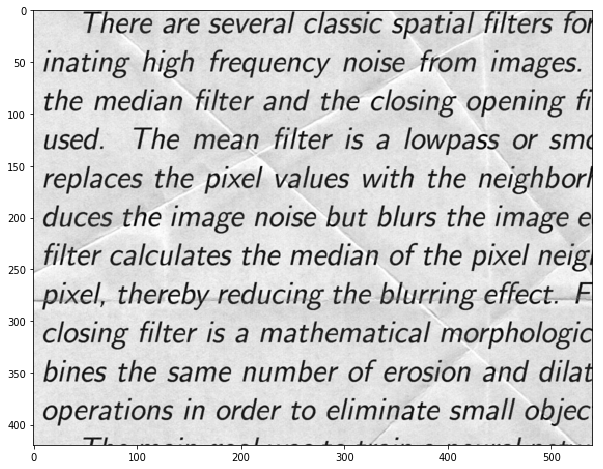

In [38]:
plt.figure(figsize=(20,8))
img = cv2.imread('train/102.png', 0)
plt.imshow(img, cmap='gray')
print(img.shape)

(420, 540)


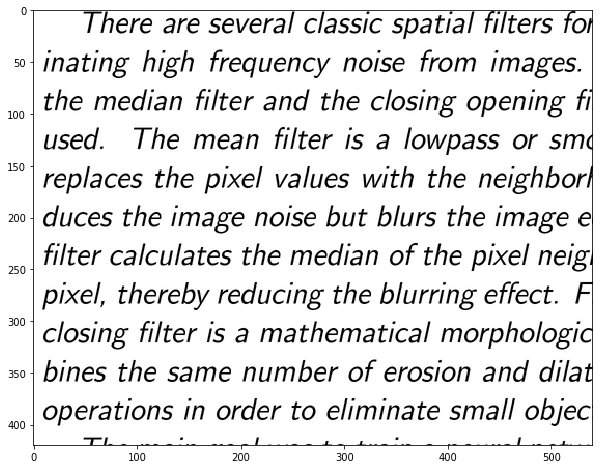

In [42]:
plt.figure(figsize=(20,8))
img = cv2.imread('train_cleaned/102.png', 0)
plt.imshow(img, cmap='gray')
print(img.shape)

In [24]:
def load_image(path):
    image_list = np.zeros((len(path), 258, 540, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, grayscale=True, target_size=(258, 540))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x
    
    return image_list

x_train = load_image(TRAIN_IMAGES)
y_train = load_image(CLEAN_IMAGES)
x_test = load_image(TEST_IMAGES)

print(x_train.shape, x_test.shape)

(144, 258, 540, 1) (72, 258, 540, 1)


In [25]:
x_train.shape

(144, 258, 540, 1)

In [26]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15)
print(x_train.shape, x_val.shape)

(122, 258, 540, 1) (22, 258, 540, 1)


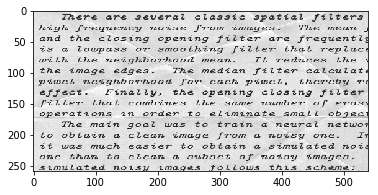

In [27]:
plt.imshow(x_train[0, :, :, 0])

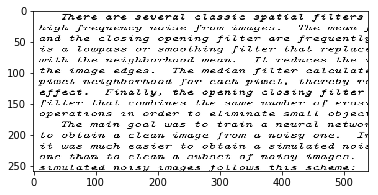

In [28]:
plt.imshow(y_train[0, :, :, 0])

In [29]:
input_layer = Input(shape=(258, 540, 1))
        
# encoder
encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)

# decoder
decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
decoder = UpSampling2D((2, 2))(decoder)
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoder)

ae = Model(input_layer, output_layer)

In [30]:
ae.compile(loss='mse', optimizer=Adam(lr=0.001))
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 258, 540, 1)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 258, 540, 64)      640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 129, 270, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 129, 270, 64)      36928     
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 258, 540, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 258, 540, 1)       577       
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
_________________________________________________________________


In [31]:
batch_size = 16
epochs = 200

early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=5,verbose=1, mode='auto')
history = ae.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), callbacks=[early_stopping])

Train on 122 samples, validate on 22 samples
Epoch 1/200
122/122 [==============================] - 2s 17ms/step - loss: 0.1448 - val_loss: 0.0700
Epoch 2/200
122/122 [==============================] - 1s 8ms/step - loss: 0.0729 - val_loss: 0.0763
Epoch 3/200
122/122 [==============================] - 1s 8ms/step - loss: 0.0772 - val_loss: 0.0742
Epoch 4/200
122/122 [==============================] - 1s 8ms/step - loss: 0.0700 - val_loss: 0.0643
Epoch 5/200
122/122 [==============================] - 1s 8ms/step - loss: 0.0624 - val_loss: 0.0576
Epoch 6/200
122/122 [==============================] - 1s 8ms/step - loss: 0.0546 - val_loss: 0.0491
Epoch 7/200
122/122 [==============================] - 1s 8ms/step - loss: 0.0453 - val_loss: 0.0395
Epoch 8/200
122/122 [==============================] - 1s 8ms/step - loss: 0.0374 - val_loss: 0.0331
Epoch 9/200
122/122 [==============================] - 1s 8ms/step - loss: 0.0323 - val_loss: 0.0290
Epoch 10/200
122/122 [=======================

Epoch 81/200
122/122 [==============================] - 1s 8ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 82/200
122/122 [==============================] - 1s 8ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 83/200
122/122 [==============================] - 1s 8ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 84/200
122/122 [==============================] - 1s 8ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 85/200
122/122 [==============================] - 1s 8ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 86/200
122/122 [==============================] - 1s 8ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 87/200
122/122 [==============================] - 1s 8ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 88/200
122/122 [==============================] - 1s 8ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 89/200
122/122 [==============================] - 1s 8ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 90/200
122/122 [==============================] - 1s 8ms/step - loss: 0.0040

In [32]:
preds = ae.predict(x_test)

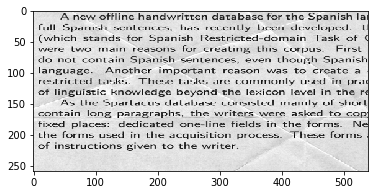

In [33]:
n = 25
preds_0 = preds[n] * 255.0
preds_0 = preds_0.reshape(258, 540)
x_test_0 = x_test[n] * 255.0
x_test_0 = x_test_0.reshape(258, 540)
plt.imshow(x_test_0, cmap='gray')

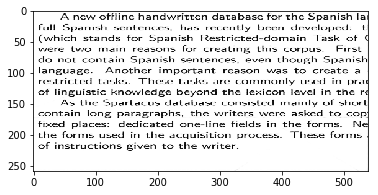

In [34]:
plt.imshow(preds_0, cmap='gray')

## Part 4: Generating New Fashion using VAEs

### Understanding VAEs

!["VAE"](http://www.cvc.uab.es/people/joans/slides_tensorflow/tensorflow_html/vae_files/ae.png)

### Reset data

In [35]:
### read dataset 
train = pd.read_csv("data/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_x, val_x = train_test_split(train_x, test_size=0.2)

## create train and validation datasets
train_x, val_x = train_test_split(train_x, test_size=0.2)

In [36]:
## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

### Setup Encoder Neural Network

Try different number of hidden layers, nodes?

In [37]:
import keras.backend as K

In [38]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

input_img = Input(shape=(784,), name="input")
x = Dense(512, activation='relu', name="intermediate_encoder")(input_img)
x = Dense(2, activation='relu', name="latent_encoder")(x)

z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

In [39]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

In [40]:
# decoder takes the latent distribution sample as input
decoder_input = Input((2,), name="input_decoder")

x = Dense(512, activation='relu', name="intermediate_decoder", input_shape=(2,))(decoder_input)

# Expand to 784 total pixels
x = Dense(784, activation='sigmoid', name="original_decoder")(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [41]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_decoder (InputLayer)   (None, 2)                 0         
_________________________________________________________________
intermediate_decoder (Dense) (None, 512)               1536      
_________________________________________________________________
original_decoder (Dense)     (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [42]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = binary_crossentropy(x, z_decoded)
        return xent_loss

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [43]:
z_decoded

<tf.Tensor 'model_4/original_decoder/Sigmoid:0' shape=(?, 784) dtype=float32>

In [44]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [45]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 784)          0                                            
__________________________________________________________________________________________________
intermediate_encoder (Dense)    (None, 512)          401920      input[0][0]                      
__________________________________________________________________________________________________
latent_encoder (Dense)          (None, 2)            1026        intermediate_encoder[0][0]       
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            6           latent_encoder[0][0]             
__________________________________________________________________________________________________
dense_2 (D

In [46]:
train_x.shape

(38400, 28, 28, 1)

In [47]:
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

In [48]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(val_x, None))

Train on 38400 samples, validate on 9600 samples
Epoch 1/20
38400/38400 [==============================] - 10s 258us/step - loss: 0.3728 - val_loss: 0.3446
Epoch 2/20
38400/38400 [==============================] - 9s 244us/step - loss: 0.3423 - val_loss: 0.3378
Epoch 3/20
38400/38400 [==============================] - 9s 245us/step - loss: 0.3369 - val_loss: 0.3380
Epoch 4/20
38400/38400 [==============================] - 9s 244us/step - loss: 0.3345 - val_loss: 0.3418
Epoch 5/20
38400/38400 [==============================] - 9s 243us/step - loss: 0.3329 - val_loss: 0.3353
Epoch 6/20
38400/38400 [==============================] - 9s 244us/step - loss: 0.3318 - val_loss: 0.3318
Epoch 7/20
38400/38400 [==============================] - 9s 242us/step - loss: 0.3309 - val_loss: 0.3307
Epoch 8/20
38400/38400 [==============================] - 9s 245us/step - loss: 0.3302 - val_loss: 0.3301
Epoch 9/20
38400/38400 [==============================] - 9s 241us/step - loss: 0.3297 - val_loss: 0.3

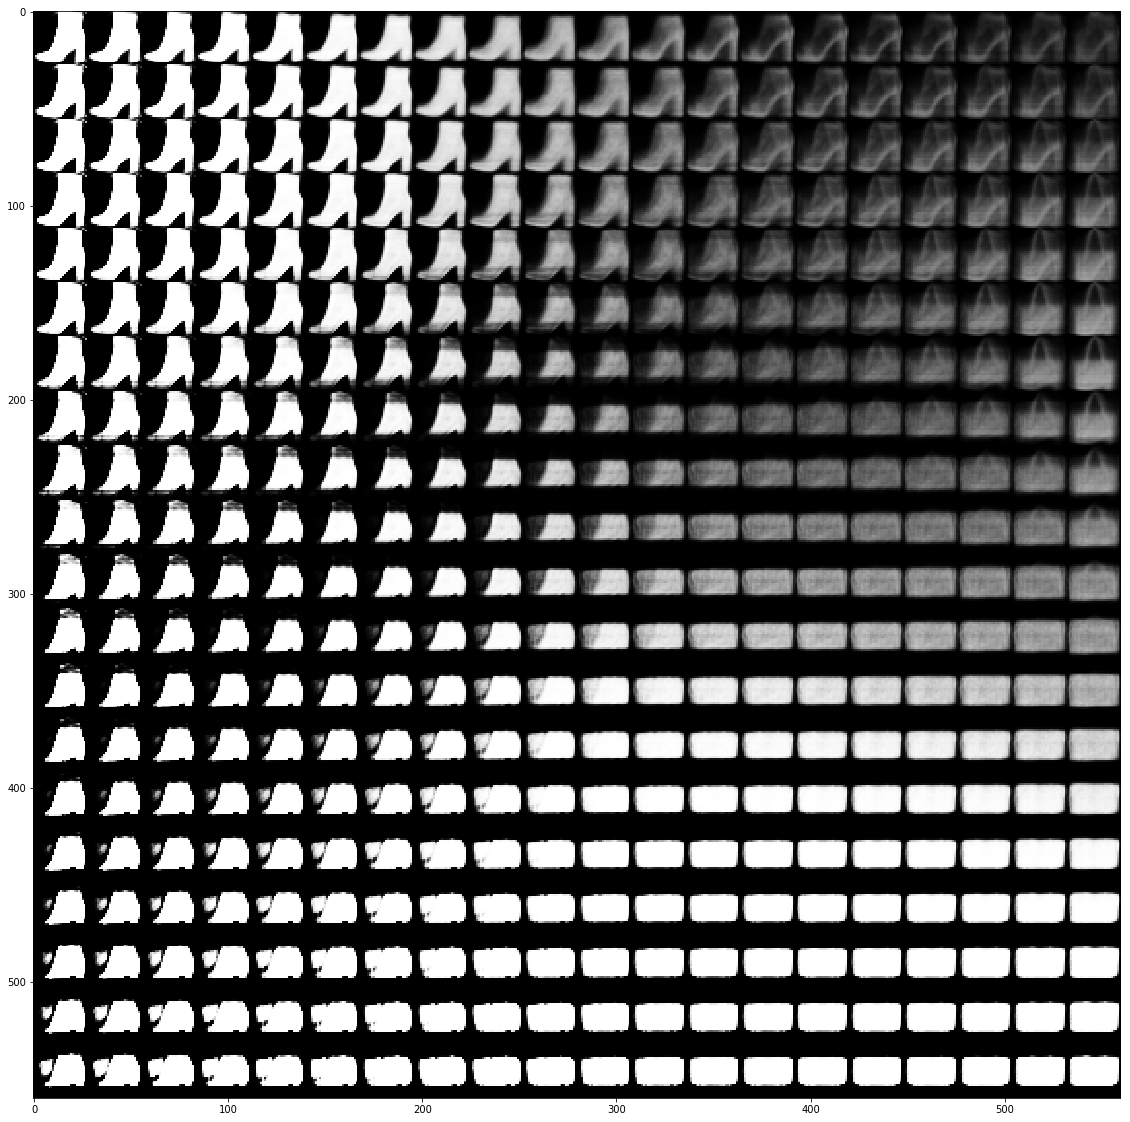

In [49]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        
        digit = x_decoded[0].reshape(digit_size, digit_size)
        
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()  

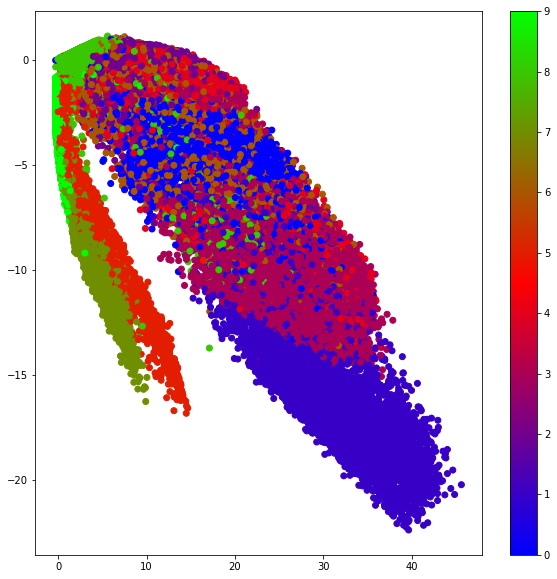

In [50]:
### read dataset 
train = pd.read_csv("data/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train[list(train.columns)[0]].values

train_x = train_x/255.
# train_x = train_x.reshape(-1, 28, 28, 1)

# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=train_y, cmap='brg')
plt.colorbar()
plt.show()

## Part 5: Exercise: Generating New Fashion using VAEs: Adding CNNs and KL Divergence Loss

In [51]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_img)
x = Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)

# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

### Set up sampling function

In [52]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

### Setup Decoder Neural Network

Try different number of hidden layers, nodes?

In [53]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

### Set up loss functions

In [54]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

### Train VAE

In [55]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [56]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_14 

In [57]:
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

In [58]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(val_x, None))

Train on 60000 samples, validate on 9600 samples
Epoch 1/20
60000/60000 [==============================] - 30s 500us/step - loss: 0.3938 - val_loss: 0.3383
Epoch 2/20
60000/60000 [==============================] - 29s 486us/step - loss: 0.3371 - val_loss: 0.3379
Epoch 3/20
60000/60000 [==============================] - 29s 490us/step - loss: 0.3337 - val_loss: 0.3315
Epoch 4/20
60000/60000 [==============================] - 29s 485us/step - loss: 0.3315 - val_loss: 0.3306
Epoch 5/20
60000/60000 [==============================] - 29s 489us/step - loss: 0.3305 - val_loss: 0.3335
Epoch 6/20
60000/60000 [==============================] - 29s 484us/step - loss: 0.3289 - val_loss: 0.3291
Epoch 7/20
60000/60000 [==============================] - 29s 491us/step - loss: 0.3283 - val_loss: 0.3299
Epoch 8/20
60000/60000 [==============================] - 29s 489us/step - loss: 0.3282 - val_loss: 0.3322
Epoch 9/20
60000/60000 [==============================] - 29s 488us/step - loss: 0.3286 - val_l

### Visualize Samples reconstructed by VAE

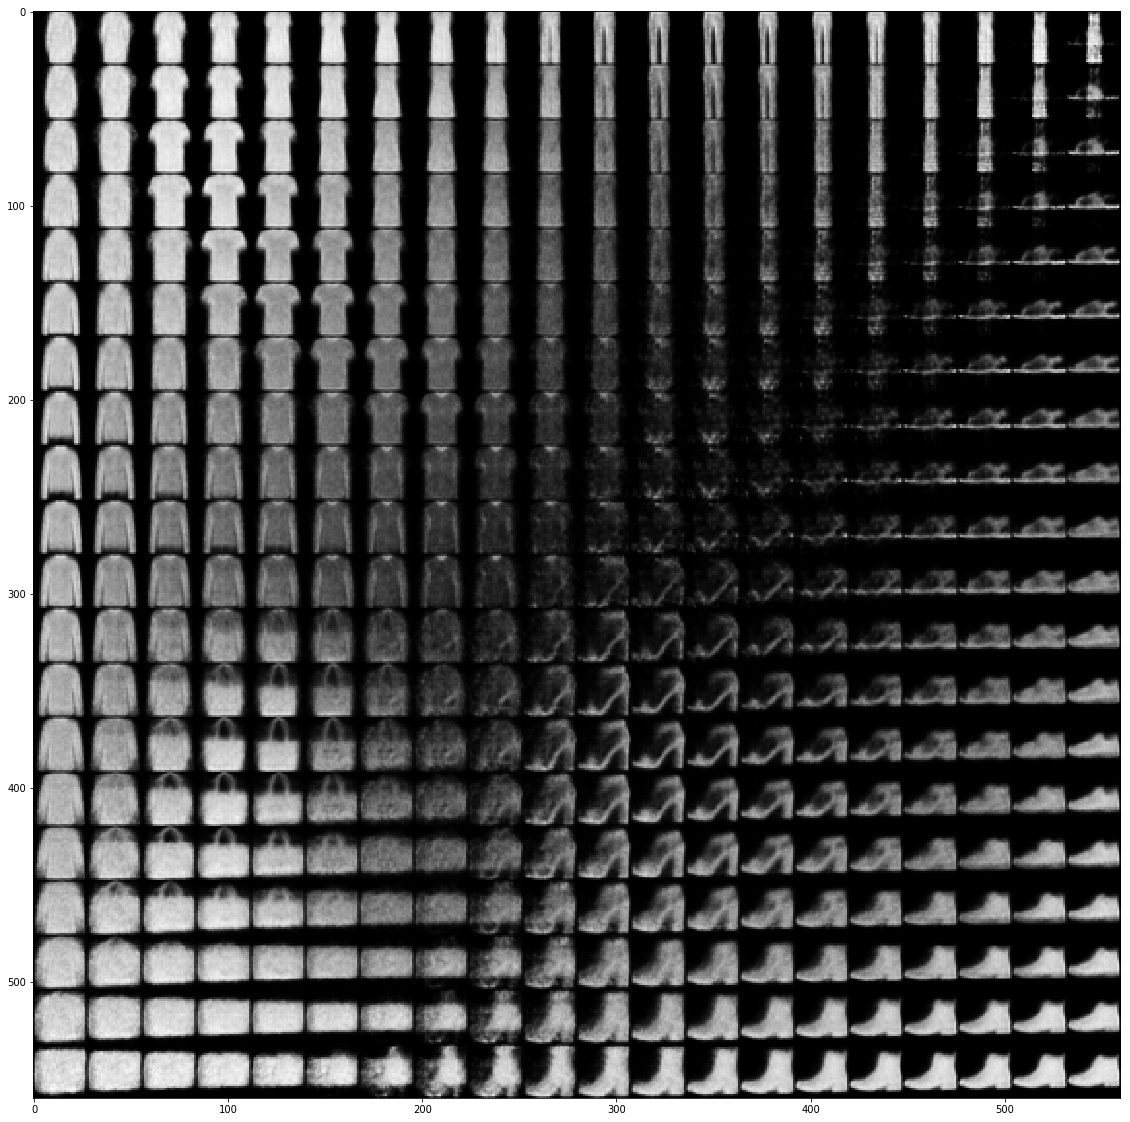

In [59]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()  

## TODO:
#### VAE: Visualize latent space

In [60]:
train = pd.read_csv("data/fashion-mnist_train.csv")


In [61]:
### read dataset 
train = pd.read_csv("data/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train[list(train.columns)[0]].values

train_x = train_x/255.
train_x = train_x.reshape(-1, 28, 28, 1)

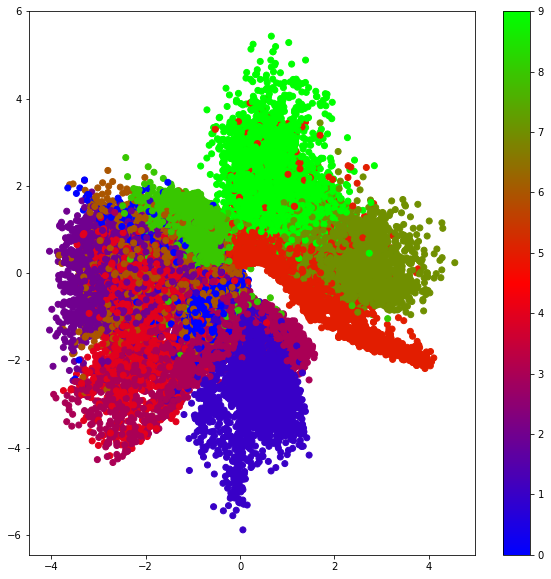

In [62]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=train_y, cmap='brg')
plt.colorbar()
plt.show()